In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, RandomizedSearchCV, cross_val_predict, cross_validate, GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler

import warnings
warnings.filterwarnings('ignore')

import shap
shap.initjs()


df_normal_quality = pd.read_csv('df_normal_quality.csv', index_col= 0).reset_index(drop = True)
y = df_normal_quality.SalePrice
X = df_normal_quality.drop(['SalePrice', 'PID'], axis =1).copy()

kf = KFold(n_splits=5, shuffle=True, random_state=42)
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)
numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)


# LASSO

In [3]:
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")               

numerical_preprocessor = RobustScaler()


preprocessor = ColumnTransformer(
    [
        ("robust_scaler", numerical_preprocessor, numerical_columns),
        ("one-hot-encoder", categorical_preprocessor, categorical_columns),
    ]
)



lasso = Lasso(alpha = 0.00030733929099045147)

lasso_pipe = Pipeline(steps=[("Preprocess", preprocessor), 
                             ("Regressor", TransformedTargetRegressor(regressor = Lasso(alpha = 0.00030733929099045147),
                                                                func =np.log, inverse_func=np.exp))])


lasso_pipe_SHAP = Pipeline(steps = [("Preprocess", preprocessor), ('lasso', lasso)])
                         
scores = cross_val_score(lasso_pipe, X, y, cv = kf, error_score='raise')

scores_SHAP = cross_val_score(lasso_pipe_SHAP, X, y, cv = kf, error_score='raise')


print('Lasso')

lasso_std = scores.std()
lasso_score = scores.mean()
print('score', lasso_score)
print('standard deviation', lasso_std)
print('      ')

lasso_pipe.fit(X,y)

lasso_predictions = lasso_pipe.predict(X)
print('predicted prices', lasso_predictions)

lasso_mae = mean_absolute_error(y, lasso_predictions)
print('Mean Absolute Error:', lasso_mae)

lasso_mpv = lasso_predictions.mean()
print ('Mean Predicted Home Value', lasso_mpv)

mhv = y.mean()
print ('Mean  Home Value', mhv)
print('      ')

print('Lasso SHAP')
print('score', scores_SHAP.mean())
print('standard deviation', scores_SHAP.std())

Lasso
score 0.9508124989217249
standard deviation 0.004995040204432598
      
predicted prices [125417.29914791 130118.74949454 115891.54733895 ... 153058.38303178
 224554.74105895 223794.23727269]
Mean Absolute Error: 10280.912930379654
Mean Predicted Home Value 172914.8587998538
Mean  Home Value 173427.01285897984
      
Lasso SHAP
score 0.921047081957437
standard deviation 0.011056554252356082


# SHAP

In [61]:
lasso_pipe.fit(X,y)

explainer_lasso_log = shap.LinearExplainer(lasso_pipe.named_steps['Regressor'].regressor_,
                          masker = lasso_pipe.named_steps['Preprocess'].transform(X))

# Calculate SHAP values for the transformed test set
shap_values_lass_log = explainer_lasso_log(lasso_pipe.named_steps['Preprocess'].transform(X))

# Get feature names after transformation
transformed_feature_names = lasso_pipe.named_steps['Preprocess'].get_feature_names_out()

# Convert SHAP values and transformed data to DataFrame for easier manipulation
# transform Explanation type into a df with named columns 
shap_values_df_lasso_log = pd.DataFrame(shap_values_lass_log.values, columns=transformed_feature_names)

categorical_prefixes = categorical_columns_selector(X)
categorical_prefixes = ["one-hot-encoder__" + word for word in categorical_prefixes]
categorical_prefixes

for prefix in categorical_prefixes:
    # Get columns that start with the prefix
    columns = [col for col in transformed_feature_names if col.startswith(prefix)]
    
    # Calculate mean SHAP value for these columns
    shap_values_df_lasso_log[prefix] = shap_values_df_lasso_log[columns].sum(axis=1)
    
    # Drop the individual encoded columns
    shap_values_df_lasso_log.drop(columns=columns, inplace=True)

# Get rid of prefixes
shap_values_df_lasso_log.columns = shap_values_df_lasso_log.columns.str.replace('robust_scaler__', 
                                                                    '', 
                                                                    regex=False)
shap_values_df_lasso_log.columns = shap_values_df_lasso_log.columns.str.replace('one-hot-encoder__', 
                                                                    '', 
                                                                    regex=False)

# reorder X columns so the original values are in the same order as the shap df
X_new_order = list(numerical_columns) + list(categorical_columns)
X_new_order =X[X_new_order]

observations = range(shap_values_df_lasso_log.shape[0])
dollar_shap_df_lasso = pd.DataFrame(columns=X_new_order.columns)
order = X_new_order.columns

for observation in observations:
    shap_values = shap_values_df_lasso_log.iloc[observation].reindex(shap_values_df_lasso_log.iloc[observation].abs().sort_values().index)
    features = shap_values.index.tolist()
    values = shap_values.values.tolist()
    bv = shap_values_lass_log.base_values[1]
    SHAPs = values
    changes = []
    
    for shaps in SHAPs:
        changes.append((np.exp(bv + shaps) - np.exp(bv)))
        bv = bv + shaps 
        
    df_change = pd.DataFrame({'Feature': features, 'Change': changes})
    df_change = df_change.set_index('Feature').T
    df_ordered_changes = df_change[order]
    dollar_shap_df_lasso.loc[observation] = df_ordered_changes.iloc[0]

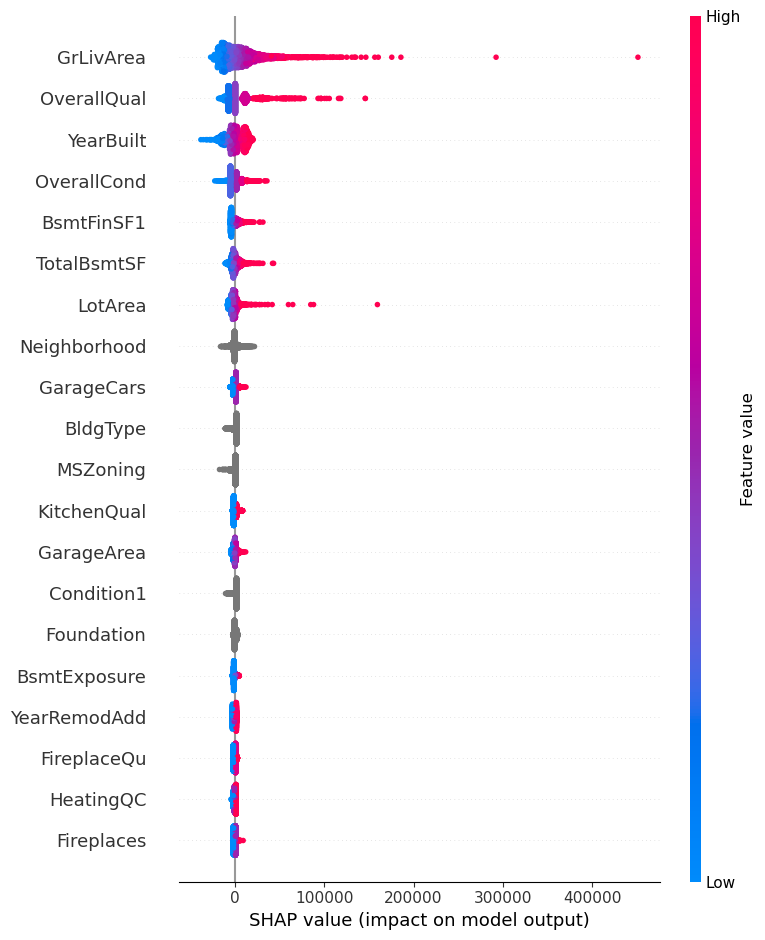

In [62]:
# Create a shap.Explanation with scaled shap values and correct feature names 
exp_lasso = shap.Explanation(dollar_shap_df_lasso.values, 
                       np.exp(shap_values_lass_log.base_values),
                       X_new_order)

shap.summary_plot(exp_lasso)

In [47]:
observations = range(2333)
dollar_shap_df = pd.DataFrame(columns=X_new_order.columns)
order = X_new_order.columns

for observation in observations:
    shap_values = shap_values_df_lasso_log.iloc[observation].reindex(shap_values_df_lasso_log.iloc[observation].abs().sort_values().index)
    features = shap_values.index.tolist()
    values = shap_values.values.tolist()
    bv = shap_values_lass_log.base_values[1]
    SHAPs = values
    changes = []
    
    for shaps in SHAPs:
        changes.append((np.exp(bv + shaps) - np.exp(bv)))
        bv = bv + shaps 
        
    df_test = pd.DataFrame({'Feature': features, 'Change': changes})
    df_test = df_test.set_index('Feature').T
    df_ordered = df_test[order]
    dollar_shap_df.loc[observation] = df_ordered.iloc[0]

dollar_shap_df


,GrLivArea,MSSubClass,LotFrontage,LotArea,Alley,LotShape,LandContour,Utilities,LandSlope,OverallQual,...,Foundation,Heating,CentralAir,Electrical,GarageType,GarageYN,PoolYN,Fence,SaleType,SaleCondition
0,-18940.465211,0.0,605.824987,-2274.454955,-16.558486,-70.598608,-6.003326,0.0,0.0,662.163182,...,-1071.388567,0.0,423.587346,0.0,-872.439830,0.0,0.0,52.045112,0.0,0.0
1,-12231.242375,0.0,1662.483722,-5796.889733,-16.559411,-70.623289,-6.003326,0.0,0.0,-6991.849767,...,-1138.556488,0.0,426.141346,0.0,563.178123,0.0,0.0,52.040675,0.0,0.0
2,-12430.577082,0.0,732.604219,-3785.494815,-16.558486,-70.629311,-6.003326,0.0,0.0,-6819.075320,...,-1965.028931,0.0,426.217938,0.0,-869.614276,0.0,0.0,52.045112,0.0,0.0
3,-10743.321757,0.0,-218.731641,-1906.864662,-16.557535,-70.633816,-6.003326,0.0,0.0,-11538.939512,...,-1834.227769,0.0,424.128924,0.0,-861.959015,0.0,0.0,52.048432,0.0,0.0
4,13608.807989,0.0,257.932731,-1960.692872,-16.557535,-70.594551,-6.003326,0.0,0.0,28644.698665,...,1885.438951,0.0,428.104695,0.0,560.369509,0.0,0.0,52.042122,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2328,-13092.548648,0.0,253.260526,-1435.971870,-16.558486,-70.607168,-6.003326,0.0,0.0,657.635099,...,-1913.289026,0.0,-4885.410875,0.0,-862.260300,0.0,0.0,52.051423,0.0,0.0
2329,11999.830432,0.0,-1589.981300,3100.735307,-16.558543,93.703243,-6.003326,0.0,0.0,-16200.880504,...,-1095.810792,0.0,424.629598,0.0,554.141517,0.0,0.0,52.037947,0.0,0.0
2330,22765.431048,0.0,-315.173382,-3417.845507,-16.560212,-70.581239,114.145117,0.0,0.0,-5870.410354,...,-1050.271580,0.0,-5136.873436,0.0,-845.042200,0.0,0.0,52.050537,0.0,0.0
2331,25176.218334,0.0,263.909363,-1574.568140,-16.558486,-70.582713,-6.003326,0.0,0.0,12711.126749,...,1951.028271,0.0,429.065208,0.0,563.239909,0.0,0.0,52.033395,0.0,0.0


In [64]:
lasso_predictions[807]

839574.0831557447

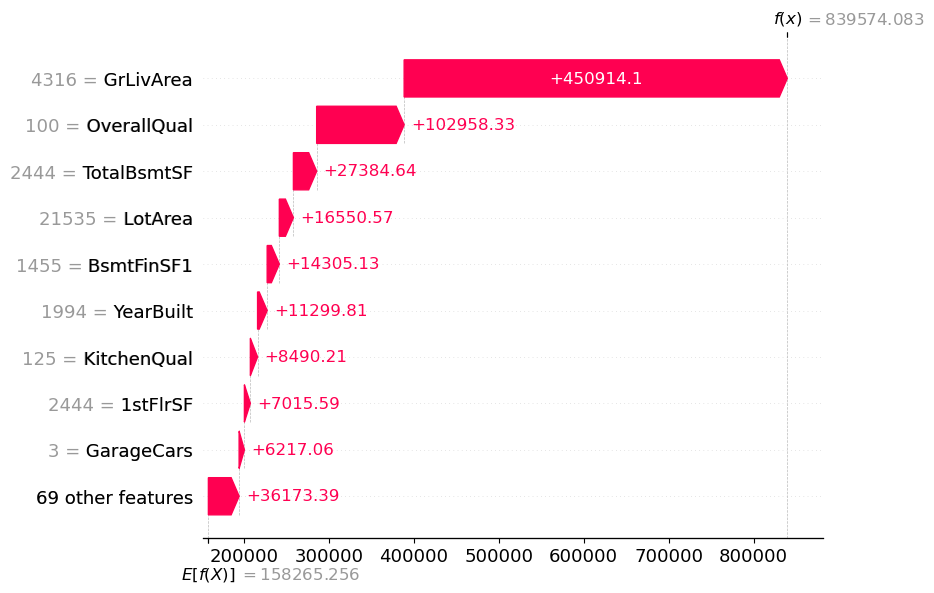

In [63]:
shap.waterfall_plot(exp_lasso[807])

In [53]:
lasso_predictions[807]

839574.0831557447

In [49]:
dollar_shap_df.sum(axis = 1) + np.exp(shap_values_lass_log.base_values[1])

0       125417.299148
1       130118.749495
2       115891.547339
3       105123.287031
4       223707.350576
            ...      
2328    107056.493708
2329    122895.059269
2330    153058.383032
2331    224554.741059
2332    223794.237273
Length: 2333, dtype: float64

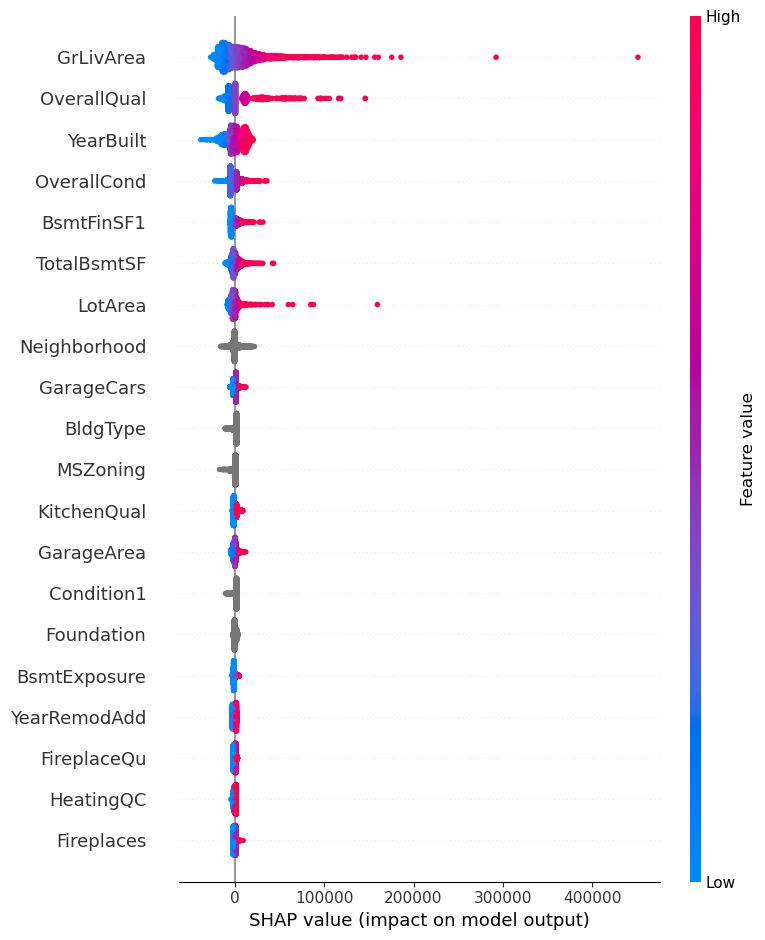

In [34]:
exp_lasso_log = shap.Explanation(dollar_shap_df.values, 
                       np.exp(shap_values_lass_log.base_values),
                       X_new_order)

shap.summary_plot(exp_lasso_log)